                                                        Introduction du projet
Contexte métier : 

Ce projet s’inscrit dans le cadre du module Concepts et Technologies IA.
Nous nous plaçons dans le rôle de consultants data intervenant auprès d’une direction Ressources Humaines.

Le problème métier adressé est celui du churn des employés, c’est-à-dire le départ volontaire de collaborateurs, phénomène qui représente un coût significatif pour l’entreprise (recrutement, formation, perte de productivité et de savoir-faire).

Nous verrons dans quelle mesure une approche Data-Driven et Machine Learning peut aider les équipes RH à mieux anticiper et comprendre le risque de départ des employés, à partir de données internes décrivant leur situation professionnelle.

L’objectif principal du projet est de prédire le churn des employés à partir de variables RH.

Lien vers le dataset : **https://www.kaggle.com/datasets/ziya07/employee-churn-data**

                                                                Plan du notebook : 

1. Chargement des données
2. Baseline naïve et métrique de référence
3. Analyse des variables et typage
4. Préprocessing et pipeline
5. Modèle de référence : Régression logistique
   - 5.1 Logistique sans pondération
   - 5.2 Logistique avec class_weight="balanced"
6. Ajustement du seuil de décision
7. Modèles non linéaires
   - 7.1 Arbre de décision
   - 7.2 XGBoost
   - 7.3 RandomForest
8. Expérience de rééquilibrage (SMOTE / SMOTENC)
9. Synthèse comparative des modèles
10. Conclusion et limites

In [88]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import mlflow
import mlflow.sklearn

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# 1. Chargement des données

In [89]:
df = pd.read_csv("employee_churn.csv")
x = df.drop(["Churn","Employee ID"],axis=1)
y = df["Churn"]
print(x.columns)

Index(['Age', 'Gender', 'Education Level', 'Marital Status', 'Tenure',
       'Job Role', 'Department', 'Salary', 'Work Location',
       'Performance Rating', 'Projects Completed', 'Training Hours',
       'Promotions', 'Overtime Hours', 'Satisfaction Level',
       'Work-Life Balance', 'Average Monthly Hours Worked', 'Absenteeism',
       'Distance from Home', 'Manager Feedback Score'],
      dtype='object')


Parmi les variables catégorielles, la colonne `Employee ID` correspond à un identifiant unique par employé.
Cette variable n'apporte aucune information explicative sur le churn et pourrait introduire du bruit ou un sur-apprentissage.  
On l'exclut donc du jeu de données avant l'entraînement des modèles.

# 2. Baseline naïve et métrique de référence

Avant d'entraîner des modèles, on vérifie la distribution de la cible `Churn`.  
Dans un problème déséquilibré, un modèle peut obtenir une accuracy élevée en prédisant uniquement la classe majoritaire.  
On met donc en place un **modèle baseline** pour disposer d'un point de comparaison.

In [90]:
print("Shape x:", x.shape)
print("\n Distribution de y:")
print(y.value_counts(normalize=True))

Shape x: (10000, 20)

 Distribution de y:
Churn
0    0.7972
1    0.2028
Name: proportion, dtype: float64


In [91]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, random_state = 42, stratify = y
)

In [92]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(x_train, y_train)
y_pred_dummy = dummy.predict(x_test)

In [93]:
print("Accuracy :", accuracy_score(y_test, y_pred_dummy))
print("Recall (churn) :", recall_score(y_test, y_pred_dummy))
print("Precision (churn) :", precision_score(y_test, y_pred_dummy))
print("F1-score :", f1_score(y_test, y_pred_dummy))

Accuracy : 0.797
Recall (churn) : 0.0
Precision (churn) : 0.0
F1-score : 0.0


C:\Users\micka\OneDrive\Documents\Ynov\Concepts_et_technos_IA\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Malgré une accuracy élevée, le modèle de référence ne détecte aucun employé ayant quitté l’entreprise. Cela montre que l’accuracy seule n’est pas une métrique pertinente car le churn est déséquilibré.

# 3. Analyse des variables et typage

Avant de construire le pipeline de préprocessing, analysons le type des variables présentes dans le jeu de données.

In [94]:
numeric_features = x.select_dtypes(include = ['int64','float64']).columns
print(numeric_features)

Index(['Age', 'Tenure', 'Salary', 'Performance Rating', 'Projects Completed',
       'Training Hours', 'Promotions', 'Overtime Hours', 'Satisfaction Level',
       'Average Monthly Hours Worked', 'Absenteeism', 'Distance from Home',
       'Manager Feedback Score'],
      dtype='object')


In [95]:
categorical_features = x.select_dtypes(include = 'object').columns
print(categorical_features)

Index(['Gender', 'Education Level', 'Marital Status', 'Job Role', 'Department',
       'Work Location', 'Work-Life Balance'],
      dtype='object')


# 4. Préprocessing et pipeline

In [96]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)

preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer, numeric_features),("cat", categorical_transformer, categorical_features)])

Le pipeline de préprocessing est désormais en place.

In [97]:
# Sauvegarde des données préprocessées
X_preprocessed = preprocessor.fit_transform(x_train)

feature_names = (
    list(numeric_features) +
    list(preprocessor.named_transformers_["cat"]
         .get_feature_names_out(categorical_features))
)

X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)

X_preprocessed_df["Churn"] = y_train.values

X_preprocessed_df.to_csv("dataset_preprocessed.csv", index=False)


# 5. Modèle de référence : Régression logistique

In [98]:
model_logreg = Pipeline(steps = [("preprocessing", preprocessor), ("classifier", LogisticRegression(max_iter=1000))])
model_logreg.fit(x_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transform

In [99]:
y_pred = model_logreg.predict(x_test)
y_proba = model_logreg.predict_proba(x_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print("\nROC-AUC:", roc_auc_score(y_test, y_proba))

[[1594    0]
 [ 406    0]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1594
           1       0.00      0.00      0.00       406

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.64      0.80      0.71      2000


ROC-AUC: 0.5137708525196087


Suite à l'entraînement et l'évaluation du premier modèle de régression logistique sur le jeu de test, les résultats montrent qu'il prédit exclusivement la classe majoritaire. Il ne détecte aucun churn. Nous allons donc ré-entraîner le modèle avec class_weight="balanced".

# 5.2 Logistique avec class_weight="balanced"

In [100]:
model_logreg_balanced = Pipeline(steps = [("preprocessing", preprocessor),("Classifier", LogisticRegression(max_iter = 1000 ,class_weight = 'balanced', random_state = 42))])

In [101]:
model_logreg_balanced.fit(x_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('Classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transform

In [102]:
y_pred_balanced = model_logreg_balanced.predict(x_test)
y_proba_balanced = model_logreg_balanced.predict_proba(x_test)[:, 1]

In [103]:
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_balanced))
print("\nClassification report:\n", classification_report(y_test, y_pred_balanced, zero_division=0))
print("\nROC-AUC:", roc_auc_score(y_test, y_proba_balanced))

Confusion matrix:
 [[804 790]
 [209 197]]

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.50      0.62      1594
           1       0.20      0.49      0.28       406

    accuracy                           0.50      2000
   macro avg       0.50      0.49      0.45      2000
weighted avg       0.67      0.50      0.55      2000


ROC-AUC: 0.513792485366924


Malgré l'utilisation de class_weight = "balanced" le modèle reste conservateur et ne détecte aucun churn. Il va donc falloir ajuster le seuil de décision pour s'aligner avec les objectifs métiers.

# 5.3 Logistique optimisée par GridSearch

In [104]:
logreg_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

In [105]:
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    scoring="recall",
    cv=cv,
    n_jobs=-1
)

grid_logreg.fit(x_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=1000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__C': [0.01, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displa

In [106]:
print("Best params:", grid_logreg.best_params_)
print("Best CV recall:", grid_logreg.best_score_)

best_logreg = grid_logreg.best_estimator_

Best params: {'classifier__C': 10}
Best CV recall: 0.48271225071225066


In [107]:
y_pred_opt = best_logreg.predict(x_test)
y_proba_opt = best_logreg.predict_proba(x_test)[:, 1]

print(confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_opt))

[[802 792]
 [209 197]]
              precision    recall  f1-score   support

           0       0.79      0.50      0.62      1594
           1       0.20      0.49      0.28       406

    accuracy                           0.50      2000
   macro avg       0.50      0.49      0.45      2000
weighted avg       0.67      0.50      0.55      2000

ROC-AUC: 0.5137909401635443


# 6. Ajustement du seuil de décision

In [108]:
y_proba = y_proba_opt
threshold = 0.30
y_pred_thresh = (y_proba >= threshold).astype(int)

In [109]:
print("Seuil = ",threshold)
print("Nb de churns prédits : ",y_pred_thresh.sum())
print("Matrice de confusion : ",confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh, digits = 3, zero_division = 0))

Seuil =  0.3
Nb de churns prédits :  1998
Matrice de confusion :  [[   2 1592]
 [   0  406]]
              precision    recall  f1-score   support

           0      1.000     0.001     0.003      1594
           1      0.203     1.000     0.338       406

    accuracy                          0.204      2000
   macro avg      0.602     0.501     0.170      2000
weighted avg      0.838     0.204     0.071      2000



Avec un seuil à 30% le modèle atteint un recall de 100% sur Churn, on identifie tous les départs. En revanche, la précision est mauvaise car beaucoup de fausses alertes. Testons avec d'autres seuils et rassemblons les résultats.

In [110]:
thresholds = [0.50, 0.45, 0.40, 0.35]
for t in thresholds :
    y_pred_t = (y_proba >= t).astype(int)
    nb_alertes = y_pred_t.sum()
    rec = recall_score(y_test, y_pred_t, zero_division = 0)
    prec = precision_score(y_test, y_pred_t, zero_division = 0)
    f1 = f1_score(y_test, y_pred_t, zero_division = 0)

    print(f"Seuil = {t} | Alertes = {nb_alertes} | Recall = {rec} | Precision = {prec} | F1 = {f1}")

Seuil = 0.5 | Alertes = 989 | Recall = 0.4852216748768473 | Precision = 0.19919110212335692 | F1 = 0.2824372759856631
Seuil = 0.45 | Alertes = 1885 | Recall = 0.9458128078817734 | Precision = 0.20371352785145888 | F1 = 0.33522479266695765
Seuil = 0.4 | Alertes = 1948 | Recall = 0.9802955665024631 | Precision = 0.20431211498973306 | F1 = 0.33814783347493627
Seuil = 0.35 | Alertes = 1962 | Recall = 0.9901477832512315 | Precision = 0.20489296636085627 | F1 = 0.33952702702702703


Sur le jeu de test, un seuil de 0.40 permet d’atteindre un rappel de 98% mais au prix d’un volume d’alertes très élevé (quasi tous les employés).

In [111]:
mlflow.set_experiment("churn_prediction")

chosen_threshold = 0.40
y_pred_04 = (y_proba_opt >= chosen_threshold).astype(int)

with mlflow.start_run(run_name=f"LogReg_optimized_threshold_{chosen_threshold:.2f}"):

    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("best_C", best_logreg.named_steps["classifier"].C)
    mlflow.log_param("threshold", chosen_threshold)
    
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba_opt))
    mlflow.log_metric("precision", precision_score(y_test, y_pred_04, zero_division=0))
    mlflow.log_metric("recall", recall_score(y_test, y_pred_04, zero_division=0))
    mlflow.log_metric("f1", f1_score(y_test, y_pred_04, zero_division=0))
    mlflow.log_metric("nb_alerts", int(y_pred_04.sum()))

    mlflow.sklearn.log_model(best_logreg, name="model")

# 7. Modèles non linéaires

Sur le jeu de test, l’analyse de plusieurs seuils met en évidence un compromis entre rappel et volume d’alertes. Un seuil de 0.40 atteint un rappel très élevé (environ 98%), mais génère un grand volume d’alertes. Ce seuil est retenu comme compromis final, en cohérence avec l’objectif métier prioritaire de minimiser les faux négatifs. Nous explorons maintenant des modèles non linéaires.

# 7.1 Arbre de décision 

In [112]:
tree_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

param_grid_tree = {
    "classifier__max_depth": [3, 4, 5, 6, None],
    "classifier__min_samples_leaf": [20, 50, 100],
    "classifier__min_samples_split": [50, 100, 200]
}

grid_tree = GridSearchCV(
    estimator=tree_pipeline,
    param_grid=param_grid_tree,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_tree.fit(x_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__max_depth': [3, 4, ...], 'classifier__min_samples_leaf': [20, 50, ...], 'classifier__min_samples_split': [50, 100, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fol

In [116]:
print("Best params:", grid_tree.best_params_)
print("Best CV recall:", grid_tree.best_score_)

Best params: {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 100}
Best CV recall: 0.6004729344729345


In [117]:
# Probas du meilleur arbre (GridSearch)
best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(x_test)
y_proba_tree = best_tree.predict_proba(x_test)[:, 1]
print("Meilleurs paramètres :", grid_tree.best_params_)
print("Best CV recall :", grid_tree.best_score_)
print("Test ROC-AUC :", roc_auc_score(y_test, y_proba_tree))
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree, zero_division=0))


Meilleurs paramètres : {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 100}
Best CV recall : 0.6004729344729345
Test ROC-AUC : 0.511114647909958
[[ 482 1112]
 [ 105  301]]
              precision    recall  f1-score   support

           0       0.82      0.30      0.44      1594
           1       0.21      0.74      0.33       406

    accuracy                           0.39      2000
   macro avg       0.52      0.52      0.39      2000
weighted avg       0.70      0.39      0.42      2000



In [118]:
print(best_tree.named_steps["classifier"])

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=20, min_samples_split=100,
                       random_state=42)


In [119]:
for thr in [0.30, 0.35, 0.40, 0.45, 0.50] :
    pred = (y_proba_tree >= thr).astype(int)
    alerts = int(pred.sum())
    prec = precision_score(y_test, pred, zero_division=0)
    rec  = recall_score(y_test, pred, zero_division=0)
    f1   = f1_score(y_test, pred, zero_division=0)

    print(f"\n Seuil = {thr} | Alerts = {alerts} | Precision = {prec:.3f} | Recall = {rec:.3f} | F1 = {f1:.3f}")
    print(confusion_matrix(y_test, pred))


 Seuil = 0.3 | Alerts = 1975 | Precision = 0.203 | Recall = 0.988 | F1 = 0.337
[[  20 1574]
 [   5  401]]

 Seuil = 0.35 | Alerts = 1975 | Precision = 0.203 | Recall = 0.988 | F1 = 0.337
[[  20 1574]
 [   5  401]]

 Seuil = 0.4 | Alerts = 1975 | Precision = 0.203 | Recall = 0.988 | F1 = 0.337
[[  20 1574]
 [   5  401]]

 Seuil = 0.45 | Alerts = 1916 | Precision = 0.205 | Recall = 0.966 | F1 = 0.338
[[  70 1524]
 [  14  392]]

 Seuil = 0.5 | Alerts = 1413 | Precision = 0.213 | Recall = 0.741 | F1 = 0.331
[[ 482 1112]
 [ 105  301]]


In [120]:
mlflow.set_experiment("churn_prediction")

chosen_threshold = 0.45
y_pred_thr = (y_proba_tree >= chosen_threshold).astype(int)

with mlflow.start_run(run_name=f"DecisionTree_balanced_thr_{chosen_threshold:.2f}"):

    mlflow.log_param("model", "DecisionTree")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("threshold", chosen_threshold)
    mlflow.log_param("best_params", str(grid_tree.best_params_))
    mlflow.log_param("cv_scoring", "recall")
    mlflow.log_metric("best_cv_recall", grid_tree.best_score_)

    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba_tree))
    mlflow.log_metric("precision", precision_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("recall", recall_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("f1", f1_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("nb_alerts", int(y_pred_thr.sum()))

    mlflow.sklearn.log_model(best_tree, name="model")


Après optimisation des hyperparamètres par GridSearchCV (CV=5, métrique = recall), l’arbre de décision obtient un meilleur compromis sur le jeu de test.
L’ajustement du seuil montre qu’un seuil de 0.45 permet d’atteindre un rappel élevé (0.966) tout en réduisant légèrement le volume d’alertes (1916).
Ce seuil est retenu comme compromis final, en cohérence avec l’objectif métier prioritaire de minimiser les faux négatifs tout en conservant un minimum de contrôle sur la charge d’alertes.

# 7.2 XGBoost

Comme nous sommes dans un contexte déséquilibré, nous utilisons `scale_pos_weight` afin de pénaliser les erreurs sur la classe minoritaire.

In [121]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=ratio,
        random_state=42,
        n_jobs=-1
    ))
])

param_grid_xgb = {
    "classifier__n_estimators": [200, 300],
    "classifier__max_depth": [3, 4, 5],
    "classifier__learning_rate": [0.03, 0.05],
    "classifier__subsample": [0.8],
    "classifier__colsample_bytree": [0.8]
}


In [122]:
grid_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_xgb,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...=None, ...))])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__colsample_bytree': [0.8], 'classifier__learning_rate': [0.03, 0.05], 'classifier__max_depth': [3, 4, ...], 'classifier__n_estimators': [200, 300], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : 

In [123]:
best_xgb = grid_xgb.best_estimator_

y_pred_xgb = best_xgb.predict(x_test)
y_proba_xgb = best_xgb.predict_proba(x_test)[:, 1]

print("Meilleurs paramètres :", grid_xgb.best_params_)
print("Best CV recall :", grid_xgb.best_score_)
print("Test ROC-AUC :", roc_auc_score(y_test, y_proba_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, zero_division=0))

Meilleurs paramètres : {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.03, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best CV recall : 0.381025641025641
Test ROC-AUC : 0.5186104295047314
[[956 638]
 [235 171]]
              precision    recall  f1-score   support

           0       0.80      0.60      0.69      1594
           1       0.21      0.42      0.28       406

    accuracy                           0.56      2000
   macro avg       0.51      0.51      0.48      2000
weighted avg       0.68      0.56      0.60      2000



In [124]:
for thr in [0.30, 0.35, 0.40, 0.45, 0.50]:
    pred = (y_proba_xgb >= thr).astype(int)
    alerts = int(pred.sum())
    prec = precision_score(y_test, pred, zero_division=0)
    rec = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)

    print(f"\nSeuil = {thr} | Alerts = {alerts} | Precision = {prec:.3f} | Recall = {rec:.3f} | F1 = {f1:.3f}")
    print(confusion_matrix(y_test, pred))


Seuil = 0.3 | Alerts = 1993 | Precision = 0.203 | Recall = 0.998 | F1 = 0.338
[[   6 1588]
 [   1  405]]

Seuil = 0.35 | Alerts = 1961 | Precision = 0.204 | Recall = 0.988 | F1 = 0.339
[[  34 1560]
 [   5  401]]

Seuil = 0.4 | Alerts = 1905 | Precision = 0.206 | Recall = 0.968 | F1 = 0.340
[[  82 1512]
 [  13  393]]

Seuil = 0.45 | Alerts = 1645 | Precision = 0.209 | Recall = 0.845 | F1 = 0.334
[[ 292 1302]
 [  63  343]]

Seuil = 0.5 | Alerts = 809 | Precision = 0.211 | Recall = 0.421 | F1 = 0.281
[[956 638]
 [235 171]]


Après optimisation des hyperparamètres via GridSearchCV (CV=5, métrique = recall), XGBoost améliore légèrement la qualité des prédictions sur le jeu de test.
L’analyse de plusieurs seuils montre qu’un seuil de 0.40 offre le meilleur compromis dans notre grille : rappel ≈ 0.968 pour la classe churn, avec 1905 alertes et un F1 = 0.34.
Un seuil plus bas (0.30–0.35) augmente encore le rappel mais conduit à un volume d’alertes quasi systématique, tandis qu’un seuil plus haut réduit fortement le rappel (donc augmente les faux négatifs).

In [125]:
chosen_threshold = 0.40
y_pred_thr = (y_proba_xgb >= chosen_threshold).astype(int)

with mlflow.start_run(run_name=f"XGBoost_GS_thr_{chosen_threshold:.2f}"):

    mlflow.log_param("model", "XGBoost")
    mlflow.log_param("best_params", str(grid_xgb.best_params_))
    mlflow.log_param("cv_scoring", "recall")
    mlflow.log_param("scale_pos_weight", ratio)
    mlflow.log_param("threshold", chosen_threshold)

    mlflow.log_metric("best_cv_recall", grid_xgb.best_score_)
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba_xgb))
    mlflow.log_metric("precision", precision_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("recall", recall_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("f1", f1_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("nb_alerts", int(y_pred_thr.sum()))

    mlflow.sklearn.log_model(best_xgb, name="model")

# 7.3 RandomForest

In [126]:
rf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

In [127]:
param_grid_rf = {
    "classifier__n_estimators": [200, 400],
    "classifier__max_depth": [5, 10, None],
    "classifier__min_samples_leaf": [10, 50, 100],
    "classifier__min_samples_split": [20, 50, 100],
    "classifier__max_features": ["sqrt", "log2"]
}

grid_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(x_train, y_train)
best_rf = grid_rf.best_estimator_

print("Meilleurs paramètres :", grid_rf.best_params_)
print("Best CV recall :", grid_rf.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres : {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 100, 'classifier__min_samples_split': 20, 'classifier__n_estimators': 200}
Best CV recall : 0.299644824311491


In [128]:
y_pred_rf = best_rf.predict(x_test)
y_proba_rf = best_rf.predict_proba(x_test)[:, 1]

print("Test ROC-AUC :", roc_auc_score(y_test, y_proba_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=0))

Test ROC-AUC : 0.5211260206068322
[[1130  464]
 [ 274  132]]
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      1594
           1       0.22      0.33      0.26       406

    accuracy                           0.63      2000
   macro avg       0.51      0.52      0.51      2000
weighted avg       0.69      0.63      0.65      2000



In [129]:
print("Min proba :", y_proba_rf.min())
print("Max proba :", y_proba_rf.max())
print("Moy proba :", y_proba_rf.mean())

Min proba : 0.4450104867260184
Max proba : 0.5354480093093619
Moy proba : 0.49219025473033706


In [130]:
mlflow.set_experiment("churn_prediction")

chosen_threshold = 0.46
y_pred_thr = (y_proba_rf >= chosen_threshold).astype(int)

with mlflow.start_run(run_name=f"RandomForest_GS_thr_{chosen_threshold:.2f}"):

    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("best_params", str(grid_rf.best_params_))
    mlflow.log_param("cv_scoring", "recall")
    mlflow.log_param("threshold", chosen_threshold)

    mlflow.log_metric("best_cv_recall", grid_rf.best_score_)
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba_rf))
    mlflow.log_metric("precision", precision_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("recall", recall_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("f1", f1_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("nb_alerts", int(y_pred_thr.sum()))

    mlflow.sklearn.log_model(best_rf, name="model")

In [131]:
for thr in [0.46, 0.48, 0.50, 0.52]:
    pred = (y_proba_rf >= thr).astype(int)
    alerts = int(pred.sum())
    prec = precision_score(y_test, pred, zero_division=0)
    rec = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)

    print(
        f"\nSeuil = {thr} | Alerts = {alerts} | "
        f"Precision = {prec:.3f} | Recall = {rec:.3f} | F1 = {f1:.3f}"
    )
    print(confusion_matrix(y_test, pred))


Seuil = 0.46 | Alerts = 1959 | Precision = 0.205 | Recall = 0.990 | F1 = 0.340
[[  37 1557]
 [   4  402]]

Seuil = 0.48 | Alerts = 1618 | Precision = 0.210 | Recall = 0.835 | F1 = 0.335
[[ 315 1279]
 [  67  339]]

Seuil = 0.5 | Alerts = 596 | Precision = 0.221 | Recall = 0.325 | F1 = 0.263
[[1130  464]
 [ 274  132]]

Seuil = 0.52 | Alerts = 43 | Precision = 0.279 | Recall = 0.030 | F1 = 0.053
[[1563   31]
 [ 394   12]]


Après optimisation des hyperparamètres via GridSearchCV, le RandomForest obtient une performance limitée sur le jeu de test (ROC-AUC = 0.52).
Les probabilités prédites sont très compressées autour de 0.5, ce qui rend le modèle très sensible au choix du seuil.
Dans notre grille, un seuil de 0.46 permet d’atteindre un rappel très élevé (0.99), mais au prix d’un volume d’alertes très important (1959).
Ce comportement confirme que RandomForest n’apporte pas de gain opérationnel clair par rapport à XGBoost/Arbre, et n’est donc pas retenu comme modèle final.

Malgré l’utilisation de modèles avancés et de techniques de rééquilibrage, les performances restent limitées. Cela suggère que la principale contrainte réside dans l’information contenue dans les variables disponibles plutôt que dans le choix du modèle. Dans ce contexte, le Random Forest offre le meilleur compromis opérationnel, mais l’amélioration future passera prioritairement par l’enrichissement des données. 

# 8. Expérience de rééquilibrage (SMOTE / SMOTENC)

Les données étant fortement déséquilibrées (environ 20 % de churn), nous testons une approche de sur-échantillonnage afin de rééquilibrer la classe minoritaire.  
Étant donnée la présence de variables catégorielles non encodées, nous utilisons **SMOTENC**, une extension de SMOTE adaptée aux données mixtes.

In [132]:
num_cols = x_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = x_train.select_dtypes(exclude=["int64", "float64"]).columns

In [133]:
preprocess_smote = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [134]:
cat_indices = [x_train.columns.get_loc(c) for c in cat_cols]

smotenc = SMOTENC(
    categorical_features=cat_indices,
    random_state=42
)

logreg = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    solver="lbfgs"
)

pipe_smote_logreg = ImbPipeline(steps=[
    ("smote", smotenc),
    ("preprocess", preprocess_smote),
    ("clf", logreg)
])

In [135]:
x_train_smote_tmp, y_train_smote_tmp = smotenc.fit_resample(x_train, y_train)
print("Avant smote :\n", y_train.value_counts())
print("Après smote :\n", y_train_smote_tmp.value_counts())

Avant smote :
 Churn
0    6378
1    1622
Name: count, dtype: int64
Après smote :
 Churn
0    6378
1    6378
Name: count, dtype: int64


In [136]:
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"]
}

grid_smote_logreg = GridSearchCV(
    estimator=pipe_smote_logreg,
    param_grid=param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_smote_logreg.fit(x_train, y_train)

best_smote_logreg = grid_smote_logreg.best_estimator_

print("Best params:", grid_smote_logreg.best_params_)
print("Best CV recall:", grid_smote_logreg.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf__C': 10, 'clf__class_weight': None}
Best CV recall: 0.40874643874643873


In [137]:
best_smote_logreg = grid_smote_logreg.best_estimator_

y_pred = best_smote_logreg.predict(x_test)
y_proba = best_smote_logreg.predict_proba(x_test)[:, 1]

print("Best params:", grid_smote_logreg.best_params_)
print("Best CV recall:", grid_smote_logreg.best_score_)
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Best params: {'clf__C': 10, 'clf__class_weight': None}
Best CV recall: 0.40874643874643873
Test ROC-AUC: 0.49828327904518793
[[914 680]
 [239 167]]
              precision    recall  f1-score   support

           0       0.79      0.57      0.67      1594
           1       0.20      0.41      0.27       406

    accuracy                           0.54      2000
   macro avg       0.49      0.49      0.47      2000
weighted avg       0.67      0.54      0.58      2000



In [138]:
for thr in [0.30, 0.35, 0.40, 0.45, 0.50]:
    pred = (y_proba >= thr).astype(int)
    alerts = int(pred.sum())
    prec = precision_score(y_test, pred, zero_division=0)
    rec = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)

    print(f"\nSeuil={thr} | Alerts={alerts} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f}")
    print(confusion_matrix(y_test, pred))


Seuil=0.3 | Alerts=1618 | Precision=0.205 | Recall=0.818 | F1=0.328
[[ 308 1286]
 [  74  332]]

Seuil=0.35 | Alerts=1478 | Precision=0.204 | Recall=0.744 | F1=0.321
[[ 418 1176]
 [ 104  302]]

Seuil=0.4 | Alerts=1277 | Precision=0.202 | Recall=0.635 | F1=0.307
[[ 575 1019]
 [ 148  258]]

Seuil=0.45 | Alerts=1075 | Precision=0.203 | Recall=0.537 | F1=0.294
[[737 857]
 [188 218]]

Seuil=0.5 | Alerts=847 | Precision=0.197 | Recall=0.411 | F1=0.267
[[914 680]
 [239 167]]


In [139]:
chosen_threshold = 0.30 
y_pred_thr = (y_proba >= chosen_threshold).astype(int)

with mlflow.start_run(run_name=f"LogReg_SMOTENC_GS_thr_{chosen_threshold:.2f}"):

    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("smote", "SMOTENC")
    mlflow.log_param("best_params", str(grid_smote_logreg.best_params_))
    mlflow.log_param("cv_scoring", "recall")
    mlflow.log_param("threshold", chosen_threshold)

    mlflow.log_metric("best_cv_recall", grid_smote_logreg.best_score_)
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba))
    mlflow.log_metric("precision", precision_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("recall", recall_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("f1", f1_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("nb_alerts", int(y_pred_thr.sum()))

    mlflow.sklearn.log_model(best_smote_logreg, name="model")

Après optimisation des hyperparamètres via GridSearchCV), la régression logistique avec SMOTENC conserve une capacité discriminante limitée (ROC-AUC environ = 0.50).
Le meilleur compromis dans notre grille de seuils est obtenu pour un seuil de 0.30 (recall = 0.82), au prix d’un volume d’alertes élevé (1618).
Malgré l’optimisation, la précision reste proche de 20 %, ce qui confirme que les variables disponibles séparent difficilement churn et non-churn, même après rééquilibrage.

Testons maintenant avec RandomForest .

In [140]:
preprocess_smote = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

cat_indices = [x_train.columns.get_loc(c) for c in cat_cols]

In [141]:
smotenc = SMOTENC(
    categorical_features=cat_indices,
    random_state=42
)

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

pipe_smote_rf = ImbPipeline(steps=[
    ("smote", smotenc),
    ("preprocess", preprocess_smote),
    ("clf", rf)
])

In [142]:
param_grid_rf_smote = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [5, 10, None],
    "clf__min_samples_leaf": [20, 50, 100],
    "clf__min_samples_split": [20, 50],
    "clf__max_features": ["sqrt", "log2"],
    "clf__class_weight": [None, "balanced"]
}

grid_smote_rf = GridSearchCV(
    estimator=pipe_smote_rf,
    param_grid=param_grid_rf_smote,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_smote_rf.fit(x_train, y_train)

best_smote_rf = grid_smote_rf.best_estimator_

print("Best params:", grid_smote_rf.best_params_)
print("Best CV recall:", grid_smote_rf.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best params: {'clf__class_weight': None, 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 50, 'clf__min_samples_split': 20, 'clf__n_estimators': 400}
Best CV recall: 0.3409363722697056


In [143]:
y_pred = best_smote_rf.predict(x_test)
y_proba = best_smote_rf.predict_proba(x_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Test ROC-AUC: 0.5161875506054108
[[1025  569]
 [ 253  153]]
              precision    recall  f1-score   support

           0       0.80      0.64      0.71      1594
           1       0.21      0.38      0.27       406

    accuracy                           0.59      2000
   macro avg       0.51      0.51      0.49      2000
weighted avg       0.68      0.59      0.62      2000



In [144]:
for thr in [0.30, 0.35, 0.40, 0.45, 0.50]:
    pred = (y_proba >= thr).astype(int)
    alerts = int(pred.sum())
    prec = precision_score(y_test, pred, zero_division=0)
    rec = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)

    print(f"\nSeuil={thr} | Alerts={alerts} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f}")
    print(confusion_matrix(y_test, pred))


Seuil=0.3 | Alerts=1972 | Precision=0.202 | Recall=0.983 | F1=0.336
[[  21 1573]
 [   7  399]]

Seuil=0.35 | Alerts=1828 | Precision=0.205 | Recall=0.921 | F1=0.335
[[ 140 1454]
 [  32  374]]

Seuil=0.4 | Alerts=1546 | Precision=0.212 | Recall=0.805 | F1=0.335
[[ 375 1219]
 [  79  327]]

Seuil=0.45 | Alerts=1102 | Precision=0.206 | Recall=0.559 | F1=0.301
[[719 875]
 [179 227]]

Seuil=0.5 | Alerts=722 | Precision=0.212 | Recall=0.377 | F1=0.271
[[1025  569]
 [ 253  153]]


In [145]:
chosen_threshold = 0.30 
y_pred_thr = (y_proba >= chosen_threshold).astype(int)

with mlflow.start_run(run_name=f"LogReg_SMOTENC_GS_thr_{chosen_threshold:.2f}"):

    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("smote", "SMOTENC")
    mlflow.log_param("best_params", str(grid_smote_logreg.best_params_))
    mlflow.log_param("cv_scoring", "recall")
    mlflow.log_param("threshold", chosen_threshold)

    mlflow.log_metric("best_cv_recall", grid_smote_logreg.best_score_)
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba))
    mlflow.log_metric("precision", precision_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("recall", recall_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("f1", f1_score(y_test, y_pred_thr, zero_division=0))
    mlflow.log_metric("nb_alerts", int(y_pred_thr.sum()))

    mlflow.sklearn.log_model(best_smote_logreg, name="model")

Pour le modèle RandomForest avec rééquilibrage SMOTENC, le seuil de décision optimal est fixé à 0.30.
Ce seuil maximise le rappel (98.3 %) et le F1-score (0.336), au prix d’un volume d’alertes élevé mais avec une précision stable autour de 20 %.
Ce choix est cohérent avec un objectif métier de détection maximale des churners, où les faux négatifs sont plus coûteux que les faux positifs.

# 9. Synthèse comparative des modèles

**Sera disponible le 20/01/2026. **

# 10. Conclusion et limites

À l’issue des différentes expérimentations menées (régression logistique, arbre de décision, Random Forest, XGBoost, avec et sans rééquilibrage), les performances globales des modèles restent limitées en capacité de discrimination, avec des valeurs de ROC-AUC proches de 0.5. Cela indique que, dans l’état actuel des données et des variables disponibles, les modèles ne parviennent pas à séparer de manière fiable les employés qui quitteront l’entreprise de ceux qui resteront.

Dans ce contexte, l’objectif initial de prédiction stricte du churn (au sens “oui/non”) apparaît peu réaliste et potentiellement trompeur d’un point de vue métier. Une prédiction binaire mal calibrée exposerait l’organisation à un volume important de fausses alertes (faux positifs) ou, à l’inverse, à des départs non anticipés (faux négatifs), avec des conséquences opérationnelles et humaines non négligeables.

En revanche, l’analyse montre que certains modèles, en particulier la régression logistique, sont capables de produire des probabilités de churn exploitables à des fins de priorisation. Bien que ces probabilités ne puissent pas être interprétées comme des estimations parfaitement calibrées du risque réel, elles constituent un indicateur relatif de vulnérabilité permettant de classer les collaborateurs selon leur niveau de risque.

Donc, l’approche retenue ne vise pas à prédire le churn, mais à probabiliser le risque de départ, afin de :

- prioriser les actions RH sur les profils les plus exposés,

- orienter des actions préventives ciblées (entretiens, accompagnement, mobilité, formation),

- réduire le risque de faux négatifs, jugés plus coûteux d’un point de vue métier qu’un excès de vigilance.

Ce choix méthodologique est cohérent avec les enjeux RH, où l’objectif n’est pas l’automatisation de décisions individuelles, mais l’aide à la décision et la détection précoce de signaux faibles. Le score produit par le modèle doit donc être interprété comme un outil d’aide à la priorisation, et non comme une vérité prédictive absolue.

Enfin, cette conclusion souligne l’importance de la qualité et de la richesse des données disponibles. Une amélioration significative des performances passerait probablement par l’intégration de variables plus fines (données temporelles, historiques de mobilité, signaux comportementaux etc...)

# Choix du modèle pour le calcul du score relatif de risque

Bien que des techniques de rééquilibrage comme SMOTE aient été testées, le modèle retenu pour le scoring final est une régression logistique entraînée sans sur-échantillonnage, avec class_weight="balanced".

Ce choix est motivé par la volonté de produire des probabilités interprétables dans un contexte métier RH. L’utilisation de SMOTE, en générant artificiellement des observations, biaise la distribution des classes et rend les scores moins représentatifs du risque réel.

# Analyse de l'importance globale des features

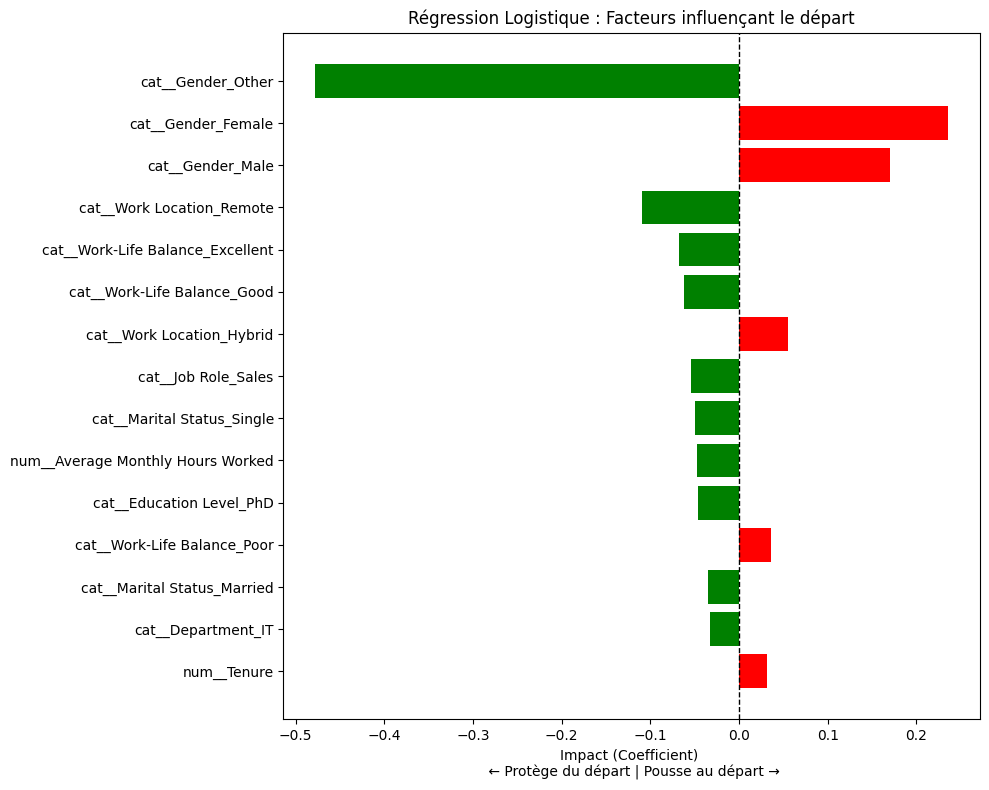

In [146]:
if hasattr(best_logreg, 'best_estimator_'):
    model_final = best_logreg.best_estimator_
else:
    model_final = best_logreg

# --- 1. RÉCUPÉRATION DES NOMS DE FEATURES ---
preprocessor_step = model_final.named_steps['preprocessing']
feature_names = preprocessor_step.get_feature_names_out()

# --- 2. RÉCUPÉRATION DES COEFFICIENTS ---
classifier_step = model_final.named_steps['classifier'] # Modifie ici si tu l'as appelé 'clf'
coefficients = classifier_step.coef_[0]

# --- 3. CRÉATION DU DATAFRAME ---
df_coeffs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Impact_Absolu': np.abs(coefficients) # Pour trier par importance
})

# On prend les 15 variables les plus impactantes (positives ou négatives)
df_top = df_coeffs.sort_values(by='Impact_Absolu', ascending=False).head(15)

# --- 4. AFFICHAGE GRAPHIQUE ---
plt.figure(figsize=(10, 8))

# Couleur : ROUGE si ça pousse au départ, VERT si ça retient l'employé
colors = ['red' if c > 0 else 'green' for c in df_top['Coefficient']]

plt.barh(df_top['Feature'], df_top['Coefficient'], color=colors)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1) # Ligne centrale
plt.title("Régression Logistique : Facteurs influençant le départ")
plt.xlabel("Impact (Coefficient) \n ← Protège du départ | Pousse au départ →")
plt.gca().invert_yaxis() # Le plus important en haut
plt.tight_layout()
plt.show()

# Interprétation 

Contrairement à nos attentes initiales, les variables Overtime Hours et Average Monthly Hours ont un impact négligeable dans ce dataset spécifique. Cela indique que dans cette entreprise simulée, le départ n'est pas déclenché par le burnout.

Le modèle se base massivement sur le Genre et la Localisation (Remote/Hybrid) pour prédire le départ. C'est un signal d'alerte important sur la qualité des données

Si nous devions déployer ce modèle demain, nous recommanderions un audit RH qualitatif pour comprendre pourquoi le Genre pèse autant, plutôt que de l'utiliser aveuglément pour prédire des départs.

# Conclusion Générale & Recommandations

## 1. Synthèse des performances
Nous avons testé plusieurs approches (Régression Logistique, XGBoost, Random Forest) avec des techniques de rééquilibrage (Class Weights) pour pallier le déséquilibre des classes (seulement 20% de départs).

* **Le Modèle Retenu :** Régression logistique avec rééquilibrage.
* **Performance Clé :** Un Rappel (Recall) élevé (~98%).
    * *Signification :* Le modèle détecte la quasi-totalité des employés qui vont partir.
* **Contrepartie :** Une Précision plus faible (~20%).
    * *Signification :* Le modèle génère des "fausses alertes" (il suspecte des employés fidèles).

## 2. Recommandations Métier
Plutôt qu'une décision binaire (Oui/Non), le modèle se veut être **outil de scoring (gestion des risques)** :

1.  **Priorisation :** Le modèle permet d'extraire une "Watchlist" des employés ayant la plus forte probabilité de départ.
2.  **Prévention :** Les RH peuvent concentrer leurs entretiens de rétention sur ce segment prioritaire.

# /!\ Il manque encore le tableau du classement des employés les plus à risques, et également le tableau récapitulatif des modèles /!\